**Import needed libraries**


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


**Import dataset**

In [12]:
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

Text(0, 0.5, 'Passengers')

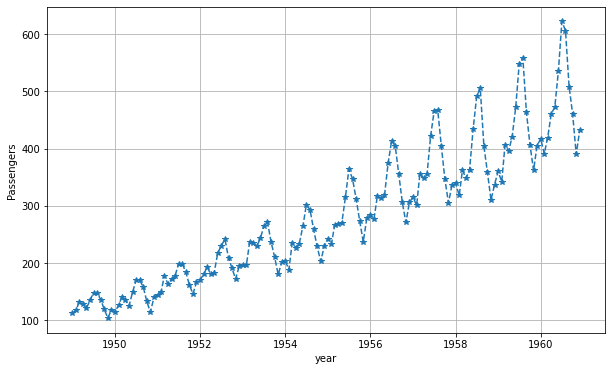

In [29]:
data["Month"] = pd.to_datetime(data["Month"])
data.set_index("Month", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(data.index, data.Passengers, "--", marker="*")
plt.grid()
plt.xlabel('year')
plt.ylabel('Passengers')

**check for missing values**

In [16]:
data.isnull().any()

Passengers    False
dtype: bool

In [19]:
# no missing data so we randomly delete data to synthesize missing data

working_data = data.copy()
rows = data.sample(frac=0.1, random_state=0)
rows["Passengers"] = np.nan
working_data.loc[rows.index, "Passengers"] = rows["Passengers"]
working_data.isnull().sum()

Passengers    14
dtype: int64

**handling the missing data**

In [20]:
#filling missing data by imputation - forwardfill

working_data_ffill = working_data.fillna(method="ffill")
working_data_ffill.isnull().sum()


Passengers    0
dtype: int64

In [21]:
#filling missing data by imputation - backwardfill

working_data_bfill = working_data.fillna(method="bfill")
working_data_bfill.isnull().sum()

Passengers    0
dtype: int64

In [22]:
#filling missing data by interpolation - 1

working_data_LIF = working_data.interpolate(method="linear", limit_direction="forward")
working_data_LIF.isnull().sum()

Passengers    0
dtype: int64

In [23]:
#filling missing data by interpolation - 2

working_data_LIB = working_data.interpolate(method="linear", limit_direction="backward")
working_data_LIB.isnull().sum()

Passengers    0
dtype: int64

In [30]:
#moving average smoothening

working_data_MA = data.copy()
MA = working_data_MA["Passengers"].rolling(12).mean()

Text(0, 0.5, 'Passengers')

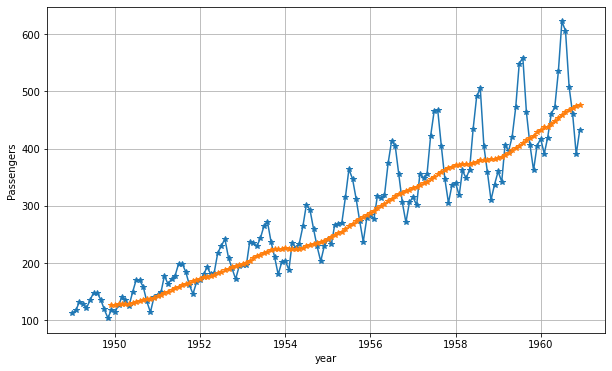

In [33]:
plt.figure(figsize=(10,6))
plt.plot(working_data_MA.index, working_data_MA.Passengers, MA, "--", marker="*")
plt.grid()
plt.xlabel('year')
plt.ylabel('Passengers')

Text(0, 0.5, 'passengers')

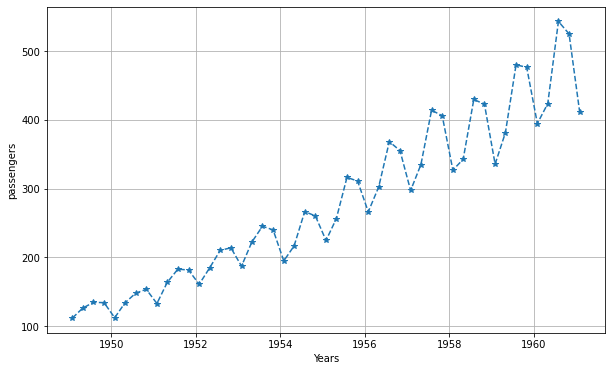

In [47]:
#downsampling to quarterly data
working_data_quarterly = data.resample('3M').mean()
plt.figure(figsize=(10,6))
plt.plot(working_data_quarterly, "--", marker="*")
plt.grid()
plt.xlabel("Years")
plt.ylabel("passengers")


In [50]:
working_data_daily = data.resample('D').mean()


Text(0, 0.5, 'Passenger')

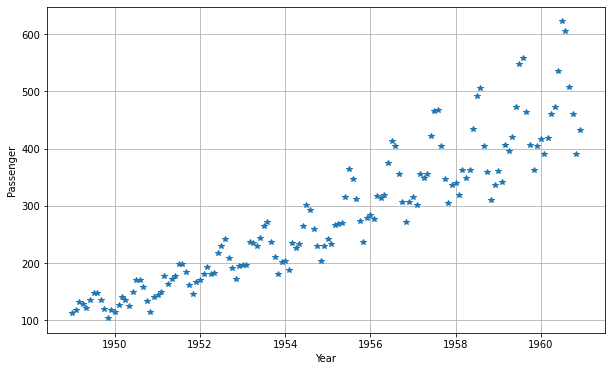

In [53]:
plt.figure(figsize=(10,6))
plt.plot(working_data_daily, "--", marker="*")
plt.grid()
plt.xlabel("Year")
plt.ylabel("Passenger")

**Time series exploratory methods**

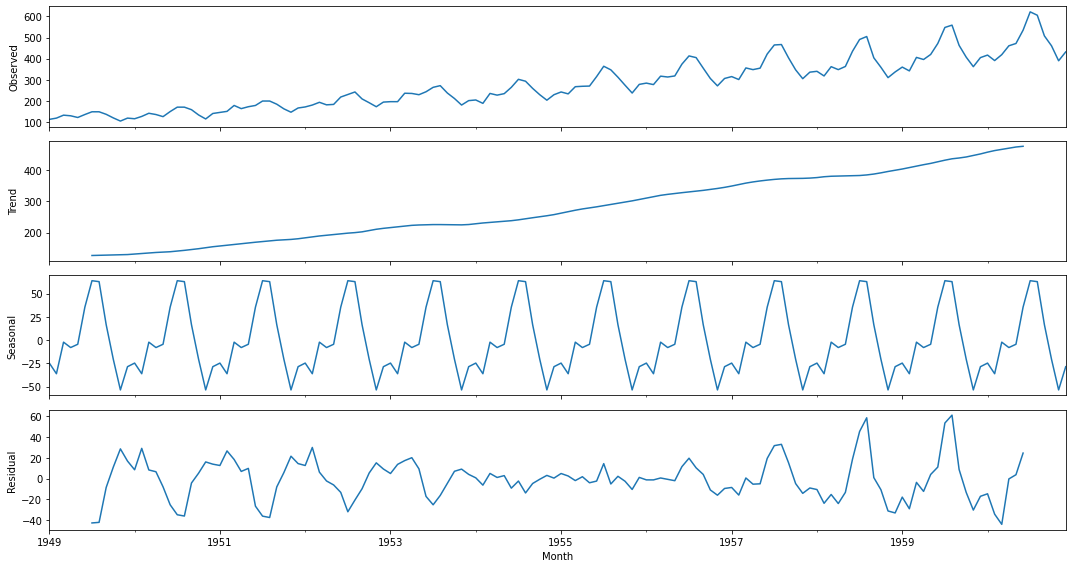

In [55]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(data["Passengers"], model = "additive")
decompose_series.plot()
plt.show()

In [57]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data["Passengers"])
print(f'Adf statistics: {adf_result[0]}')
print(f'p-values: {adf_result[1]}')
print(f'No of lags used: {adf_result[2]}')
print(f'No of observations used: {adf_result[3]}')
print("Critical values:")
for k, v in adf_result[4].items():
  print(f' {k}: {v}')

Adf statistics: 0.815368879206047
p-values: 0.991880243437641
No of lags used: 13
No of observations used: 130
Critical values:
 1%: -3.4816817173418295
 5%: -2.8840418343195267
 10%: -2.578770059171598


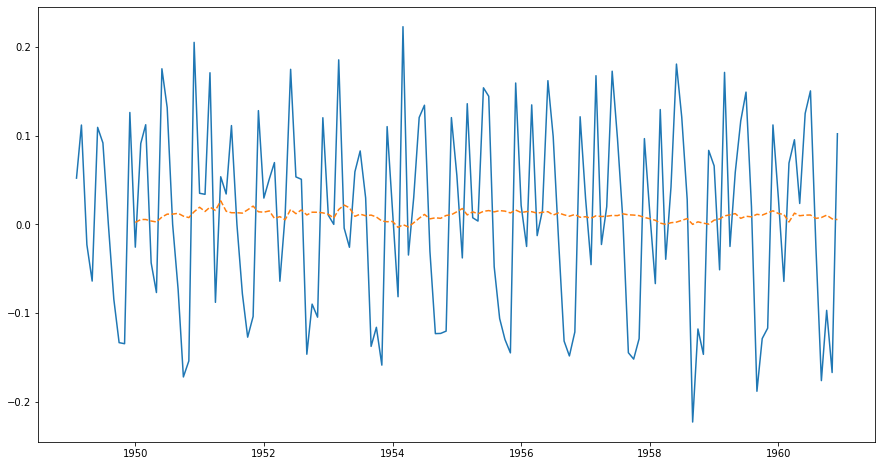

In [59]:
#convert the time series data from exponential to stationary
working_data_log = np.log(data)
working_data_diff = working_data_log.diff(periods = 1)
mean_data = working_data_diff.rolling(12).mean()
plt.plot(working_data_diff.index, working_data_diff.Passengers, mean_data, "--")


**Modelling started**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


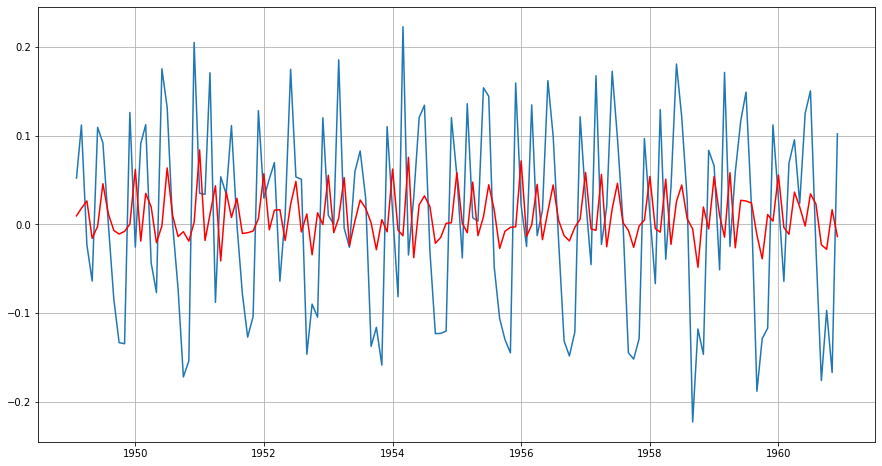

In [68]:
from statsmodels.tsa.arima_model import ARIMA
#working_data_diff.dropna(inplace=True)
# p,d,q = 2,0,0
AR_model = ARIMA(working_data_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(working_data_diff)
plt.plot(AR_model_results.fittedvalues, color = "red")
plt.grid()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


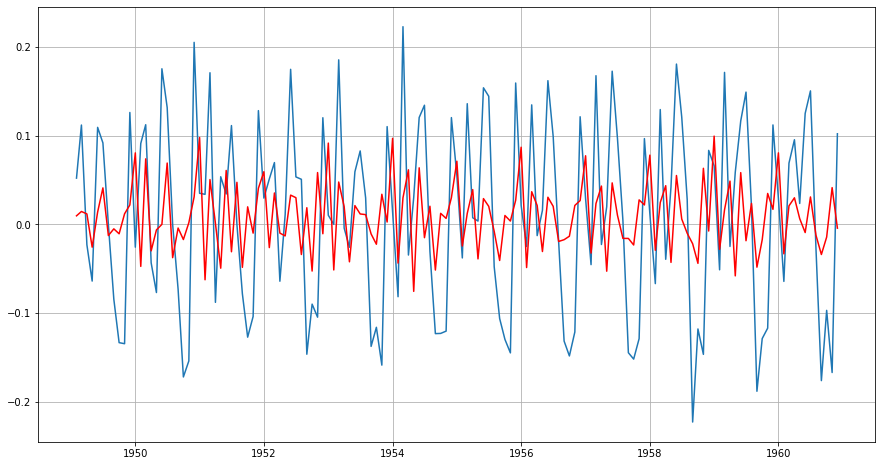

In [73]:
#p,d,q = 0,0,2
MA_model = ARIMA(working_data_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(working_data_diff)
plt.plot(MA_model_results.fittedvalues, color="red")
plt.grid()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


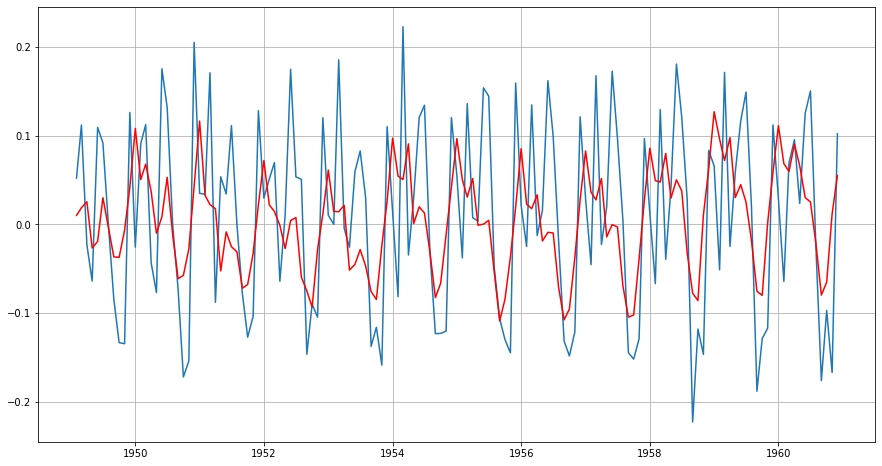

In [75]:
#p,d,q = 2,0,1
ARIMA_model = ARIMA(working_data_diff, order=(2,0,1))
ARIMA_model_result = ARIMA_model.fit()
plt.plot(working_data_diff)
plt.plot(ARIMA_model_result.fittedvalues, color="red")
plt.grid()

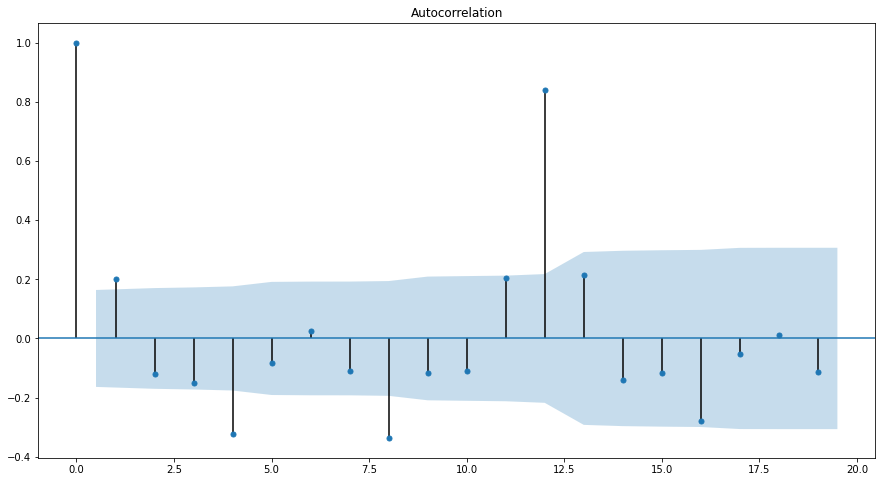

In [69]:
from statsmodels.tsa.stattools import  acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#ACF
plot_acf(working_data_diff, lags= range(0, 20))
plt.show()

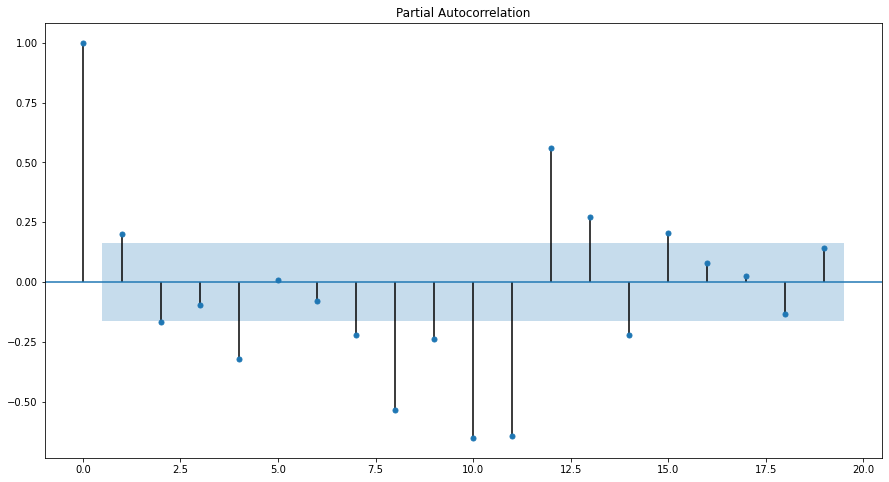

In [70]:
#PACF
plot_pacf(working_data_diff, lags= range(0, 20))
plt.show()

In [76]:
from fbprophet import Prophet

model = Prophet()

predict_data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")

In [81]:
predict_data["Month"] = pd.to_datetime(predict_data["Month"])
predict_data.rename(columns={"Month": "ds", "Passengers":"y"}, inplace=True)
predict_data.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [82]:
model.fit(predict_data)

#predict for next 10 months
future = model.make_future_dataframe(periods=10, freq="M")
forecast = model.predict(future)
forecast.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.727984,55.335253,113.075960,106.727984,106.727984,-21.920631,-21.920631,-21.920631,-21.920631,-21.920631,-21.920631,0.0,0.0,0.0,84.807353
1,1949-02-01,108.901201,47.742181,106.756864,108.901201,108.901201,-30.682847,-30.682847,-30.682847,-30.682847,-30.682847,-30.682847,0.0,0.0,0.0,78.218354
2,1949-03-01,110.864107,79.819469,139.513045,110.864107,110.864107,-0.502710,-0.502710,-0.502710,-0.502710,-0.502710,-0.502710,0.0,0.0,0.0,110.361397
3,1949-04-01,113.037323,79.120249,135.468740,113.037323,113.037323,-5.185501,-5.185501,-5.185501,-5.185501,-5.185501,-5.185501,0.0,0.0,0.0,107.851823
4,1949-05-01,115.140437,81.670472,141.915181,115.140437,115.140437,-3.788702,-3.788702,-3.788702,-3.788702,-3.788702,-3.788702,0.0,0.0,0.0,111.351735


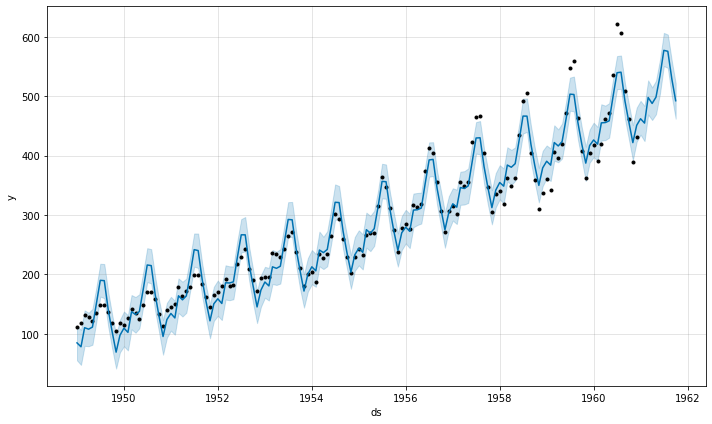

In [83]:
model.plot(forecast)
plt.show()

Text(0, 0.5, 'passengers')

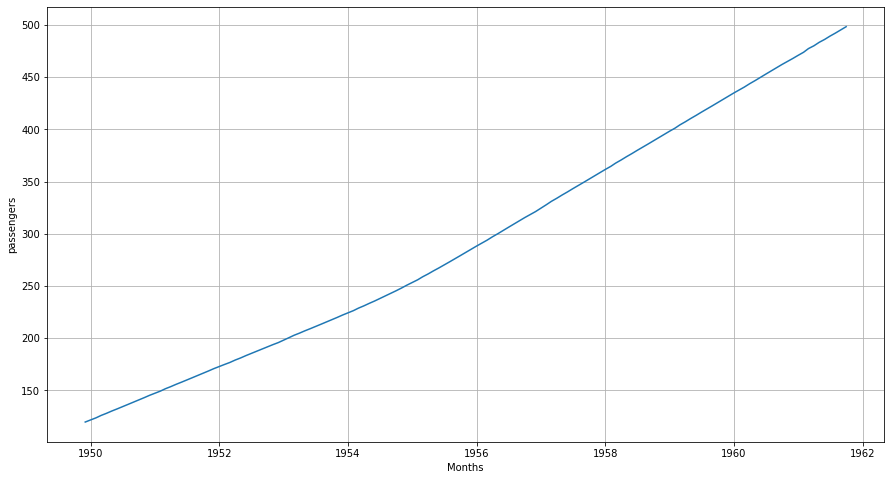

In [87]:
#moving average smoothening for forecasted data

forecasted_MA = forecast["yhat"].rolling(12).mean()

plt.plot(forecast.ds, forecasted_MA, )
plt.grid()
plt.xlabel("Months")
plt.ylabel("passengers")
